# 🌌 Photo-Z Challenge: Training Pipeline

Welcome to the Photo-Z Challenge! 🚀 This notebook provides a step-by-step guide to run the machine learning pipeline to predict redshift. 

We will learn from a baseline dataset representing nominal observational conditions. The training set is composed of 300,000 galaxies and 20,000 QSOs (Quasars).

Let's start by setting up our environment 🛠️

In [1]:
# --- 2. LIBRARIES ---
import os
import yaml
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import joblib
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
from sklearn.ensemble import RandomForestRegressor

/var/folders/6r/hl4s187n5b37619mh7d94nb40000gn/T/ipykernel_85192/1086959399.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## ⚙️ Step 1: Configuration Definition

We define the entire experiment configuration here. This dictionary contains the feature selection, model hyperparameters, and training settings.

For example, the Artificial Neural Network (ANN) uses two hidden layers with 64 neurons each and dropout rates of 0.1.

A key step is choosing which variables the ML models will use for training, such as magnitudes, J-PAS narrow-band photometry, or a combination of both. J-PAS fluxes are normalized to the **iSDSS** band by construction. Magnitudes, however, are **not** normalized and will only be normalized if they are included in `features_to_normalize`.

Note that not all observations are available for every object. Missing measurements are represented as `np.nan` values. In this configuration, observational errors are not used.

In [21]:
# Experiment and model configuration embedded directly in the notebook
cfg = {
    "experiment": {
        "group_name": "Forest-Z",
        "save_dir": "models/"
    },
    "data": {
        "train_path": "data/training_set.h5", # Adjusted path assuming notebook is in photoz_challenge/
        "val_path": "data/validation_set.h5",
        "batch_size": 1000,
        "target_col": "Z",
        "inputs": {
            "FilterJPAS": [
                'J0378', 'J0390', 'J0400', 'J0410', 'J0420', 'J0430', 'J0440', 'J0450',
                'J0460', 'J0470', 'J0480', 'J0490', 'J0500', 'J0510', 'J0520', 'J0530',
                'J0540', 'J0550', 'J0560', 'J0570', 'J0580', 'J0590', 'J0600', 'J0610',
                'J0620', 'J0630', 'J0640', 'J0650', 'J0660', 'J0670', 'J0680', 'J0690',
                'J0700', 'J0710', 'J0720', 'J0730', 'J0740', 'J0750', 'J0760', 'J0770',
                'J0780', 'J0790', 'J0800', 'J0810', 'J0820', 'J0830', 'J0840', 'J0850',
                'J0860', 'J0870', 'J0880', 'J0890', 'J0900', 'J0910'
            ],
            "MAGNITUDES": [
                'MAG_NUV','MAG_FUV','MAG_G','MAG_R','MAG_i','MAG_Z',"MAG_J_2MASS",
                "MAG_H_2MASS","MAG_Ks_2MASS",'MAG_W1','MAG_W2','MAG_W3','MAG_W4', 'iSDSS'
            ]
        },
        "selected_features": ["FilterJPAS", "MAGNITUDES"],
        "features_to_normalize": ["MAGNITUDES"]
    },
    "model": {
        "type": "random_forest", # Options: "neural_net", "random_forest"
        "hidden_layers": [512, 512],
        "dropout_rates": [0.2, 0.2],
        "output_size": 1,
        "n_estimators": 500,
        "max_depth": 100
    },
    "training": {
        "epochs": 20,
        "learning_rate": 0.001,
        "loss_type": "deltaz"
    }
}

## 🧠 Step 2: Model Architectures

Here we define the machine learning algorithms used in the pipeline. By default, the workflow includes two models: an Artificial Neural Network (ANN) and a Random Forest (RF).

We also define a custom `DeltaZLoss` function designed to optimize the standard photometric redshift (Photo-$z$) metric, defined as:

$$
\Delta z = \frac{\left| z_{\mathrm{pred}} - z_{\mathrm{true}} \right|}{1 + z_{\mathrm{true}}}
$$

where $z_{\mathrm{pred}}$ is the predicted redshift and $z_{\mathrm{true}}$ is the spectroscopic (true) redshift.

You are encouraged to experiment with alternative loss functions depending on the scientific objective or optimization strategy.

In [22]:
class PhotoZNet(nn.Module):
    def __init__(self, input_size, hidden_layers, dropout_rates):
        super(PhotoZNet, self).__init__()
        
        layers = []
        in_dim = input_size
        
        # Dynamic construction of hidden layers
        for h_dim, drop_rate in zip(hidden_layers, dropout_rates):
            layers.append(nn.Linear(in_dim, h_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(drop_rate))
            in_dim = h_dim
            
        # Linear output layer
        layers.append(nn.Linear(in_dim, 1))
        
        self.net = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.net(x)

class DeltaZLoss(nn.Module):
    def __init__(self):
        super(DeltaZLoss, self).__init__()
        
    def forward(self, y_pred, y_true):
        # Standard Photo-Z metric: |dz| / (1+z)
        numerator = torch.abs(y_pred - y_true)
        denominator = 1.0 + y_true
        return torch.mean(numerator / denominator)

class RandomForestPhotoZ:
    def __init__(self, n_estimators=100, max_depth=None):
        self.model = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            n_jobs=-1,
            random_state=42
        )

    def fit(self, X, y):
        self.model.fit(X, y.ravel())

    def predict(self, X):
        # Calculate predictions from all individual trees to estimate uncertainty
        preds = np.array([tree.predict(X) for tree in self.model.estimators_])
        mean_pred = np.mean(preds, axis=0)
        std_pred = np.std(preds, axis=0) 
        return mean_pred, std_pred

    def save(self, path):
        joblib.dump(self.model, path)

## 🗂️ Step 3: Data Processing

Data is the fuel for our models! Here we define our `Dataset` class and the `preprocess_data` function.

This function handles missing values by replacing NaNs with `0.0` and applies normalization using the Median Absolute Deviation (MAD). The median and MAD are computed **only on the training set** to prevent data leakage into the validation set.

You may also explore alternative strategies for handling missing data and different normalization approaches.

In [23]:
class PhotoZDataset(Dataset):
    def __init__(self, features, targets, types):
        self.features = torch.FloatTensor(features)
        self.targets = torch.FloatTensor(targets).reshape(-1, 1)
        self.types = np.array(types)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx], self.types[idx]

def get_mad(series):
    median = series.median()
    return (series - median).abs().median()

def preprocess_data(df, config, train_stats=None):
    selected_cols = []
    for group in config['data']['selected_features']:
        selected_cols.extend(config['data']['inputs'][group])
    
    X = df[selected_cols].copy()
    y = df['Z'].values
    types = df['TYPE'].values

    # Replace NaN values with 0.0
    X = X.fillna(0.0)

    # Identify columns that need normalization
    cols_to_norm = []
    for group in config['data']['features_to_normalize']:
        if group in config['data']['selected_features']:
             cols_to_norm.extend(config['data']['inputs'][group])
    
    # Compute median and MAD only for the training set to prevent data leakage
    if train_stats is None:
        medians = X[cols_to_norm].median()
        mads = X[cols_to_norm].apply(get_mad)
        # Prevent division by zero
        mads = mads.replace(0, 1.0)
        train_stats = {'medians': medians, 'mads': mads}
    
    # Apply normalization using the training statistics
    X[cols_to_norm] = (X[cols_to_norm] - train_stats['medians']) / train_stats['mads']
    
    return X.values, y, types, train_stats, len(selected_cols)

## 🏋️‍♂️ Step 4: Training Pipeline Execution

Time to train! 🔥 The `run_training` function orchestrates the whole process:
1. Loads the `.h5` files into Pandas DataFrames.
2. Preprocesses the data.
3. Initializes the chosen model (Neural Network or Random Forest) based on `config.yaml`.
4. Trains the model and evaluates it dynamically on validation GALAXY and QSO types.

Note: if you choose the RF, the code below uses only **10%** of the data for speed. You may want to disable this subsampling to train on the full dataset.

In [24]:
def run_training(cfg):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    print("Loading data...")
    df_train = pd.read_hdf(cfg['data']['train_path'], key='data')
    df_val = pd.read_hdf(cfg['data']['val_path'], key='data')

    print("Preprocessing data...")
    X_train, y_train, types_train, stats, input_dim = preprocess_data(df_train, cfg, train_stats=None)
    X_val, y_val, types_val, _, _ = preprocess_data(df_val, cfg, train_stats=stats)

    model_type = cfg['model'].get('type', 'neural_net')
    os.makedirs(cfg['experiment']['save_dir'], exist_ok=True)
    
    history = {'train': [], 'val_global': []}

    if model_type == 'neural_net':
        train_dataset = PhotoZDataset(X_train, y_train, types_train)
        val_dataset = PhotoZDataset(X_val, y_val, types_val)
        
        train_loader = DataLoader(train_dataset, batch_size=cfg['data']['batch_size'], shuffle=True, drop_last=True)
        val_loader = DataLoader(val_dataset, batch_size=cfg['data']['batch_size'], shuffle=False)
        
        print(f"Initializing model '{cfg['experiment']['group_name']}'...")
        model = PhotoZNet(
            input_size=input_dim,
            hidden_layers=cfg['model']['hidden_layers'],
            dropout_rates=cfg['model']['dropout_rates']
        ).to(device)

        criterion = DeltaZLoss() if cfg['training']['loss_type'] == 'deltaz' else nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=cfg['training']['learning_rate'])

        epochs = cfg['training']['epochs']
        print(f"Starting training for {epochs} epochs.")

        for epoch in range(epochs):
            model.train()
            train_loss_acc = 0.0
            
            pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]", leave=False)
            for inputs, targets, _ in pbar:
                inputs, targets = inputs.to(device), targets.to(device)
                
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
                
                train_loss_acc += loss.item()
                pbar.set_postfix({'loss': f"{loss.item():.4f}"})
            
            avg_train_loss = train_loss_acc / len(train_loader)

            model.eval()
            val_loss_acc = 0.0
            all_val_outputs, all_val_targets, all_val_types = [], [], []
            
            with torch.no_grad():
                for v_inputs, v_targets, v_types in val_loader:
                    v_inputs, v_targets = v_inputs.to(device), v_targets.to(device)
                    v_outputs = model(v_inputs)
                    v_loss = criterion(v_outputs, v_targets)
                    
                    val_loss_acc += v_loss.item()
                    all_val_outputs.append(v_outputs.cpu())
                    all_val_targets.append(v_targets.cpu())
                    all_val_types.extend(v_types)
                
                total_val_loss = val_loss_acc / len(val_loader)
                val_outputs_cat = torch.cat(all_val_outputs)
                val_targets_cat = torch.cat(all_val_targets)
                val_types_np = np.array(all_val_types)
                
                unique_types = np.unique(val_types_np)
                type_metrics = {}
                for t in unique_types:
                    mask = (val_types_np == t)
                    if np.sum(mask) > 0:
                        type_metrics[t] = criterion(val_outputs_cat[mask], val_targets_cat[mask]).item()

            msg = f"Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f} | Val Loss Global: {total_val_loss:.4f}"
            for t, l in type_metrics.items():
                msg += f" | {t}: {l:.4f}"
            print(msg)

            history['train'].append(avg_train_loss)
            history['val_global'].append(total_val_loss)
            for t, l in type_metrics.items():
                k = f"val_{t}"
                if k not in history:
                    history[k] = []
                history[k].append(l)

        save_path = os.path.join(cfg['experiment']['save_dir'], f"{cfg['experiment']['group_name']}.pth")
        torch.save(model.state_dict(), save_path)
        print(f"\nModel saved to: {save_path}")

    elif model_type == 'random_forest':
        # Sample 10% of the training data for speed (you may want to disable this)
        n_sample = max(1, int(0.1 * X_train.shape[0]))
        sample_indices = np.random.choice(X_train.shape[0], size=n_sample, replace=False)
        X_train, y_train, types_train = X_train[sample_indices], y_train[sample_indices], types_train[sample_indices]

        print(f"Initializing Random Forest model '{cfg['experiment']['group_name']}'...")
        rf_model = RandomForestPhotoZ(
            n_estimators=cfg['model'].get('n_estimators', 100),
            max_depth=cfg['model'].get('max_depth', None)
        )
        
        print("Training Random Forest...")
        rf_model.fit(X_train, y_train)
        
        print("Evaluating Random Forest on validation set...")
        mean_pred, std_pred = rf_model.predict(X_val)
        
        y_val_flat = y_val.ravel()
        numerator = np.abs(mean_pred - y_val_flat)
        denominator = 1.0 + y_val_flat
        total_val_loss = np.mean(numerator / denominator)
        
        unique_types = np.unique(types_val)
        type_metrics = {}
        for t in unique_types:
            mask = (types_val == t)
            if np.sum(mask) > 0:
                type_metrics[t] = np.mean(
                    np.abs(mean_pred[mask] - y_val_flat[mask]) / (1.0 + y_val_flat[mask])
                )
        
        msg = f"Val Loss Global: {total_val_loss:.4f}"
        for t, l in type_metrics.items():
            msg += f" | {t}: {l:.4f}"
        print(msg)
        
        history['val_global'].append(total_val_loss)
        for t, l in type_metrics.items():
            k = f"val_{t}"
            if k not in history:
                history[k] = []
            history[k].append(l)

        save_path = os.path.join(cfg['experiment']['save_dir'], f"{cfg['experiment']['group_name']}_rf.joblib")
        rf_model.save(save_path)
        print(f"\nModel saved to: {save_path}")

    return history

history = run_training(cfg)

Using device: cpu
Loading data...
Preprocessing data...
Initializing Random Forest model 'Forest-Z'...
Training Random Forest...
Evaluating Random Forest on validation set...
Val Loss Global: 0.0752 | GALAXY: 0.0552 | QSO: 0.1954

Model saved to: models/Forest-Z_rf.joblib


## 📉 Step 5: Learning Curves Visualization

In order to understand how our Neural Network is learning, we need to look at the **Loss vs. Epoch** plot! 

This plot will help us diagnose if our model is **underfitting** (high loss on both train and validation), **overfitting** (train loss goes down, but validation loss goes up), or training perfectly! We break down the validation loss into the global metric, and the specific metrics for **Galaxies** and **QSOs**  to see if the model struggles with a particular type of object.

Learning curves only available for ANN algorithm


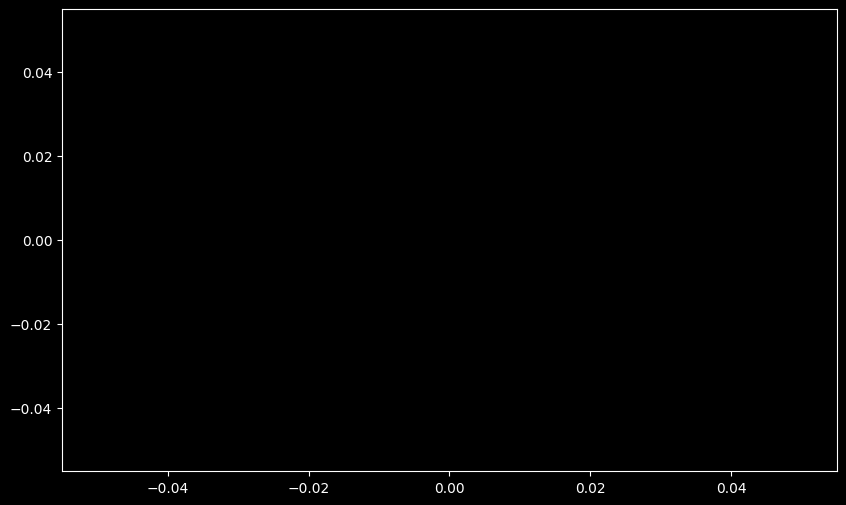

In [25]:
import matplotlib.pyplot as plt

plt.style.use('dark_background')

def plot_learning_curves(history):
    """
    Plot training and validation losses as a function of epoch.

    Expected 'history' dictionary format:
    {
        'train': [loss_ep1, loss_ep2, ...],
        'val_global': [loss_ep1, loss_ep2, ...],
        'val_GALAXY': [loss_ep1, loss_ep2, ...],
        'val_QSO': [loss_ep1, loss_ep2, ...]
    }

    The loss corresponds to the standard photometric redshift metric:

        Δz = |z_pred − z_true| / (1 + z_true)

    where:
        z_pred : predicted redshift
        z_true : spectroscopic (true) redshift
    """

    # Determine the number of epochs from the training history length
    epochs = range(1, len(history['train']) + 1)

    plt.figure(figsize=(10, 6))

    # Plot main loss curves with thicker lines
    plt.plot(epochs, history['train'],
             label='Train Loss', linewidth=3, color='cyan')

    plt.plot(epochs, history['val_global'],
             label='Val Loss (Global)', linewidth=3, color='magenta')

    # Plot class-specific validation losses if available
    if 'val_GALAXY' in history and len(history['val_GALAXY']) > 0:
        plt.plot(epochs, history['val_GALAXY'],
                 label='Val Loss (GALAXY)',
                 linewidth=3, linestyle='--', color='yellow')

    if 'val_QSO' in history and len(history['val_QSO']) > 0:
        plt.plot(epochs, history['val_QSO'],
                 label='Val Loss (QSO)',
                 linewidth=3, linestyle='-.', color='lime')

    # Axis labels
    plt.xlabel('Epoch', fontsize=16)
    plt.ylabel(r'Loss ($\Delta z$)', fontsize=16)

    # Larger tick labels
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    # Disable grid for cleaner dark-background visualization
    plt.grid(False)

    # Legend formatting
    plt.legend(loc='upper right', fontsize=14)

    plt.title('Learning Curves', fontsize=18)
    plt.tight_layout()
    plt.show()

try :
    plot_learning_curves(history)
except :
    print('Learning curves only available for ANN algorithm')
